# Household Stratification by Income
## 2017

This section assigns household cells to an income class based on the average earnings of the census tract the cell belongs to.

The main rationale is after Villaça, who describes the (re)structuring of the intra-urban space as mainly conditioned by the locational decisions of the upper income strata, while the popular classes do as best as they with the places that are left for them. Industries have also an important part to play, generally speaking, but they should not be that much influent in Belo Horizonte municipality, given their smaller relative presence.

In that context, we are faced with a definition problem: who are the upper strata or, simply put, who are the rich? This is an unsolved issue, but loosely inspired by Souza (2016, p. 21), we will consider as rich the group with the top 15% earnings in the 2010 Census income distribution.

Then, following Furtado et al (2012), we assume the same relative structure between social strata remains constant throughout the years, that is, the relative size of the rich and the poor is assumed to be constant throughout the simulation period. This assumption is to be further discussed later on, along with calibration and validation issues.

- Souza, P. H. G. F. D. (2016). A desigualdade vista do topo: a concentração de renda entre os ricos no Brasil, 1926-2013.

In [1]:
import folium
import os
import pathlib
import re

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from shapely.geometry import mapping, Point, Polygon

%matplotlib inline
%config InlineBackend.figure_format='retina'

## Preliminaries

### Parent Folders

These should of course be adjusted to reflect the appropriate locations in your disk or wherever

In [2]:
out_folder = os.environ.get('OUT_FOLDER')
out_folder = pathlib.Path(out_folder)
out_folder = out_folder / 'A'

db_folder = os.environ.get('DB_FOLDER')
db_folder = pathlib.Path(db_folder)

In [3]:
re_path = r'(BH_)(hex_\d{1,2})(_with_land_uses\.gpkg)'

for file in out_folder.iterdir():
    match = re.search(re_path, file.name)
    # If there's no search result, match is None
    if match:
        path_to_hexes = file
        index_name = match.group(2) # .group() is one-indexed
                   
hex_ = gpd.read_file(path_to_hexes, layer='2017')
hex_.rename(columns={'index': index_name}, inplace=True)
hex_.set_index(index_name, inplace=True) 

C:\Users\brand\anaconda3\envs\pyGeo\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [4]:
def get_stats(group):
    return {'min': group.min(), 'median': group.median(),
            'max': group.max(), 'count': group.count()}

cut = pd.qcut(hex_.income,
              [0, 0.85, 1],
              labels=['poor', 'rich'])

hex_['income_class'] = cut

hex_.groupby(cut)['income'].apply(get_stats).unstack()

,min,median,max,count
income,,,,
poor,0.000000,1029.541529,3424.33,118440.0
rich,3424.729197,5310.020000,35101.25,20889.0


(596923.480970482, 620747.22587796, 7780043.409061071, 7814479.196207651)

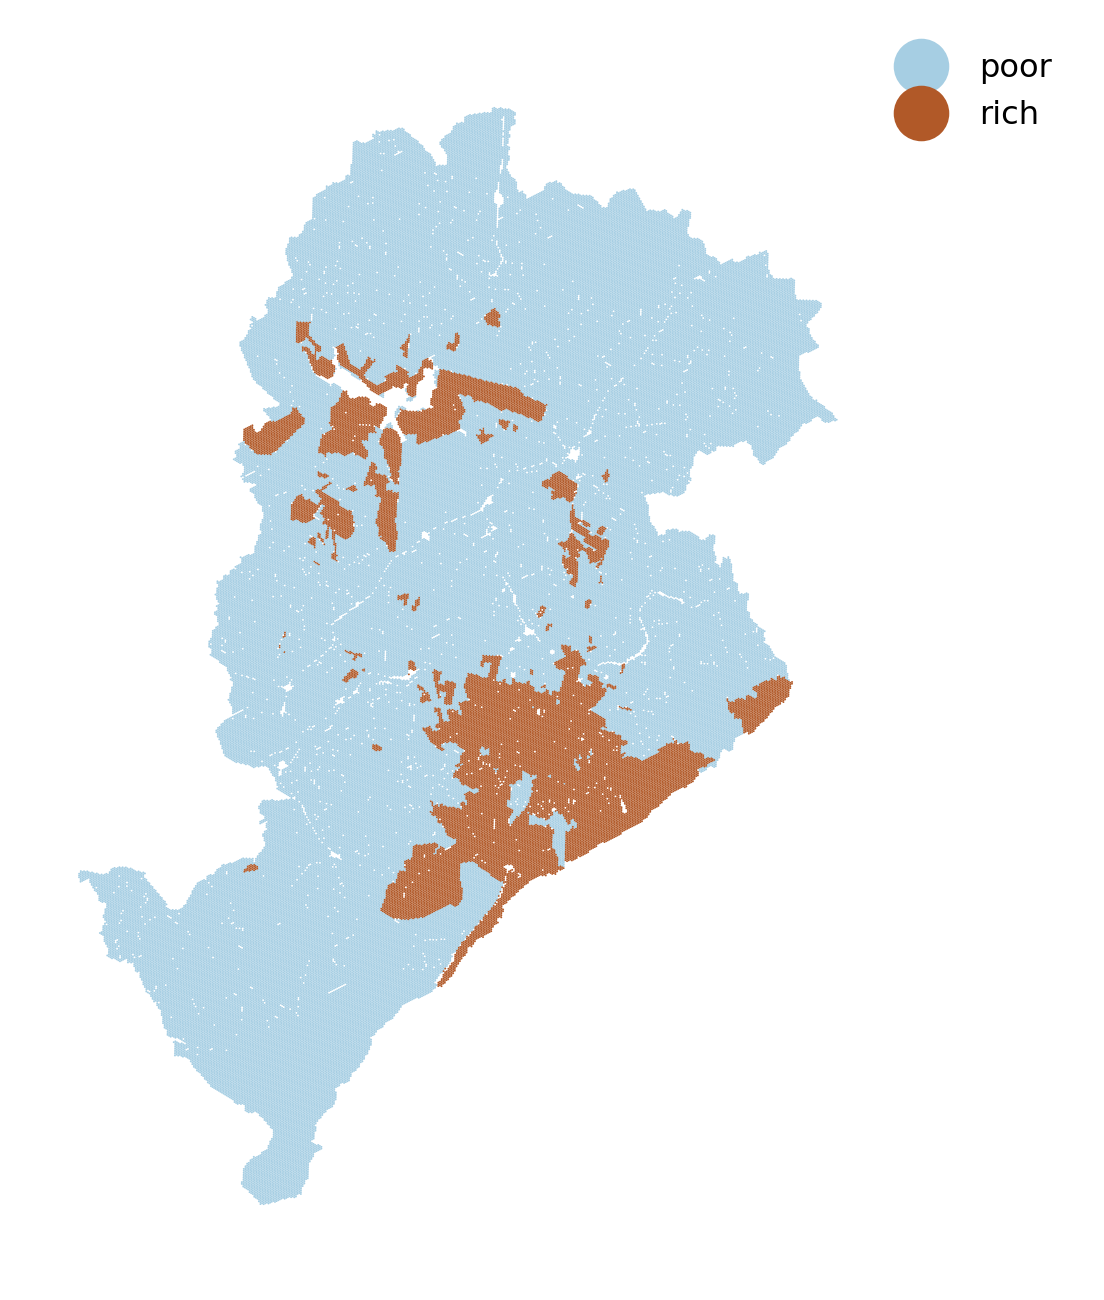

In [5]:
legend_kwds = {
    'loc': 'upper left',
    'bbox_to_anchor': (1,1.01),
    'ncol': 1,
    'borderaxespad': 0,
    'frameon':False,
    'fontsize': 'xx-small',
}

fig,ax = plt.subplots(dpi=200)
hex_.plot(ax=ax,
          column='income_class',
          cmap='Paired',
          categorical=True,
          legend=True,
          legend_kwds=legend_kwds,)
ax.axis('off')

In [8]:
# Income class if a Categorical dtype, which is not interpreted by
# gpkg. Hence it is converted to string before writing to file
hex_['income_class'] = hex_.income_class.astype(str)

hex_.to_file(path_to_hexes, layer='2017', driver='GPKG')